##SETUP

In [6]:
import os
import time
import pandas as pd
import numpy as np
# Android ADB
from scrcpy import Client, const

# Image processing
from PIL import Image
import cv2
import pytesseract
# Notebook
from IPython.display import display,clear_output
from tqdm.notebook import trange, tqdm
# internal
import bot_core
import bot_perception

import importlib
importlib.reload(bot_core)
importlib.reload(bot_perception)

bot = bot_core.Bot()
# Evaluate grid to update OCR images
names=bot.scan_grid()
grid_df=bot_perception.grid_status(names)
display(grid_df)

,grid_id,unit,probability,rank,rank_error,position,Age
0,icon_0,empty.png,999.0,0,0.0,"[0, 0]",0.0
1,icon_1,lightning.png,222.0,2,620.0,"[0, 1]",0.0
2,icon_2,empty.png,999.0,0,0.0,"[0, 2]",0.0
3,icon_3,hunter.png,680.0,1,1379.5,"[0, 3]",0.0
4,icon_4,lightning.png,588.0,1,2484.5,"[0, 4]",0.0
5,icon_5,sharpshooter.png,197.0,1,1314.5,"[1, 0]",0.0
6,icon_6,empty.png,999.0,0,0.0,"[1, 1]",0.0
7,icon_7,sharpshooter.png,294.0,2,570.0,"[1, 2]",0.0
8,icon_8,alchemist.png,303.0,1,1502.0,"[1, 3]",0.0
9,icon_9,priest.png,181.0,1,1545.0,"[1, 4]",0.0


In [13]:
# Check if alive
bot.client.control.text("test")


b'\x01\x00\x00\x00\x04test'

## Look for icons

In [5]:
bot.getScreen()

In [106]:
# Check current screen
bot.get_current_icons(False)

,icon,available,"pos [X,Y]"
0,0cont_button.png,False,"(0, 0)"
1,1quit.png,False,"(0, 0)"
2,back_button.png,False,"(0, 0)"
3,battle_icon.png,False,"(0, 0)"
4,fighting.png,True,"(669, 1359)"
5,pvp_button.png,False,"(0, 0)"


In [16]:
bot.click_button(pos)
#bot.click(460,1560)


In [ ]:
#bot.getScreen()
# Battle icon
#bot.crop_img(360,1420,180,180,name='battle_icon.png')
# PVP button
#bot.crop_img(140,1260,200,80,name='pvp_button.png')
#back button
#bot.crop_img(60,1480,70,70,name='back_button.png')
#continue button
#bot.crop_img(380,1460,70,70,name='cont_button.png')
#fight_portal
bot.crop_img(670,1360,60,60,name='fighting.png')

Image.open('fighting.png')



## Parse Grid

In [87]:
# great for unit type 
#top_box=(180,970)
#box_size=(60,60)
#gap=60

#slightly cropped
#top_box=(170,960)
#box_size=(90,90)
#gap=30c
#full grid
top_box=(153,945)
box_size=(120,120)
gap=0


## RGB split

In [151]:
def match_unit(file_name,guess_unit=True):
    # Compare each channel
    current_icons=[]
    img_rgb = cv2.imread(file_name)
    img_disp = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(img_disp,'RGB'))
    # Check every target in dir
    for target in os.listdir("units"):
        grid_id=file_name.split('_')[2].split('.')[0]
        x=0 # reset position
        y=0
        # Load icon, 90x90 pixel out of 120 pixel box
        imgSrc=f'units/{target}'
        template = cv2.imread(imgSrc)
        #template = template[0:10,15:30]
        #template = template[80:,10:-10]
        template_disp = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
        display(Image.fromarray(template_disp,'RGB'))
        match=0
        # Compare each channel
        for i in range(3):
            img_channel=img_rgb[:,:,i]
            template_ch= template[:,:,i]
            # Compare images
            res = cv2.matchTemplate(img_channel, template_ch, cv2.TM_SQDIFF_NORMED)
            min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
            match += max_val/3
        if target == 'empty.png': # make empty slightly less likely
            match+=0.05
        current_icons.append([target,match])
    unit_df=pd.DataFrame(current_icons, columns=['icon_'+grid_id,'probability'])
    unit_df['probability']=unit_df['probability'].round(4)
    if not guess_unit:
        return unit_df
    if guess_unit:
        guess=unit_df.loc[unit_df['probability'].idxmin()]
        unit_pred = guess[0]
        if guess[1]>0.6:
            unit_pred = 'empty.png'
        return [unit_df.columns[0],unit_pred,guess[1]]

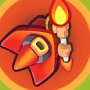

In [157]:

img_rgb = cv2.imread('OCR_inputs/icon_7.png')
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
Image.fromarray(img_gray,'L')
Image.fromarray(img_rgb,'RGB')


# Add icon

In [8]:
# Convert to unit icon 
def crop_img(input, x, y, dx, dy, name='icon.png'):
    # Load screen
    img_rgb = cv2.imread(input)
    img_rgb = img_rgb[y:y + dy, x:x + dx]
    # Convert to grayscale (done internally by tessarct )
    #img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)
    #(a, img_gray) = cv2.threshold(img_rgb, 127, 255, cv2.THRESH_BINARY)
    cv2.imwrite(name, img_rgb)
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(img_rgb))

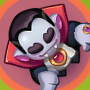

In [11]:
# Add unit
name = 'vampire.png'
crop_img('OCR_inputs/icon_3.png',17,15,90,90,name)

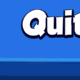

In [97]:
# Add button
name = 'quit.png'
crop_img('emulator-5554-screenshot.png',440,1460,80,80,name)

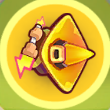

In [12]:
# Add rank
name = 'rank1.png'
crop_img('OCR_inputs/icon_8.png',5,5,110,110,name)

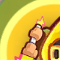

In [60]:
# Add rank
name = 'rank1.png'
crop_img('OCR_inputs/icon_8.png',5,5,60,60,name)

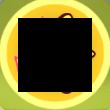

In [8]:
# cuts out middle pixels from unit icon
def crop_rank(input,name=input):
    img_rgb = cv2.imread(input)
    keep=18
    img_rgb[keep:-keep,keep:-keep] = 0
    cv2.imwrite(name, img_rgb)
    #display
    img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(img_rgb))

crop_rank('rank1.png','rank1_C.png')

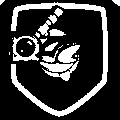

In [34]:
# cuts out middle pixels from unit icon
def image_to_binary(input,name=input):
    img = cv2.imread(input)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    keep=30
    #gray[keep:-keep,keep:-keep] = 255
    #thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    thresh = cv2.threshold(gray,180,255,cv2.THRESH_BINARY)[1]
    cv2.imwrite(name, thresh)
    display(Image.fromarray(thresh))
name = 'rank5.png'
image_to_binary('OCR_inputs/icon_11.png',name)

In [103]:
#df_split, df_groups, unit_list = bot_core.get_unit_count(grid_df)
df_groups.sort_values(ascending=False)

unit
lightning.png    5
empty.png        3
fire_mage.png    3
archer.png       2
cold_mage.png    2
Name: unit, dtype: int64

In [11]:
np.shape(img_rgb[:,:,0])

(110, 110, 3)